## Import

In [ ]:
# ! pip install mplfinance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import os
import datetime

import mplfinance as mpf
from decimal import Decimal

## Load Data

In [3]:
df = pd.read_csv('../dataset/preprocessed_data.csv', index_col=0)
df.head()

,date,time,open,high,low,close,prevClose,vol
0,20100216,901,207.55,207.65,207.50,207.60,207.5,3985
1,20100216,902,207.60,207.65,207.25,207.55,207.5,5095
2,20100216,903,207.55,207.80,207.50,207.60,207.5,2175
3,20100216,904,207.55,207.85,207.55,207.80,207.5,1301
4,20100216,905,207.80,208.15,207.80,208.05,207.5,3870


In [ ]:
df.isnull().sum() # 결측치가 있는지 확인 

open         0
high         0
low          0
close        0
prevClose    0
vol          0
dtype: int64

In [ ]:
df.shape == df.drop_duplicates().shape # 따라서 추가적인 전처리는 필요하지 않을 것 

True

### 지표 추가

In [4]:
# time 열이 '908' 같은 숫자거나 float일 수 있으니 정제하기 
df['time'] = df['time'].apply(lambda x: f"{int(float(x)):04d}")  # 908 -> '0908'

# date와 time을 문자열로 변환하고 붙이기
df['datetime_str'] = df['date'].astype(str) + df['time']

# datetime으로 변환
df['datetime'] = pd.to_datetime(df['datetime_str'], format='%Y%m%d%H%M')

df.drop(['date','time','datetime_str'], axis=1, inplace=True) # datatime으로 통합된 지표 삭제 

In [6]:
df = df.set_index('datetime')
df

,open,high,low,close,prevClose,vol
datetime,,,,,,
2010-02-16 09:01:00,207.55,207.65,207.50,207.60,207.50,3985
2010-02-16 09:02:00,207.60,207.65,207.25,207.55,207.50,5095
2010-02-16 09:03:00,207.55,207.80,207.50,207.60,207.50,2175
2010-02-16 09:04:00,207.55,207.85,207.55,207.80,207.50,1301
2010-02-16 09:05:00,207.80,208.15,207.80,208.05,207.50,3870
...,...,...,...,...,...,...
2020-04-03 15:32:00,231.40,231.40,231.30,231.35,231.65,876
2020-04-03 15:33:00,231.35,231.40,231.30,231.35,231.65,586
2020-04-03 15:34:00,231.40,231.40,231.30,231.30,231.65,210


## 기초 정보 

In [73]:
# 데이터의 시작과 끝 (date)
str(df.index[0].date()), str(df.index[-1].date())

('2010-02-16', '2020-04-03')

데이터는 2010년 2월 16일부터 2020년 4월 3일까지 수집된 것으로, 2020년도는 코로나가 터졌을 때 선물 지표를 반영한다.  

In [159]:
df.shape

(941119, 6)

## 데이터 기준 변경 
현재는 분봉이 기준인데 설정에 따라 시봉 - 일봉 - 월봉 - 년봉을 볼 수 있게 만든다. 

In [ ]:
def down_sampling(df, interval:str):
    "'min'=분, 'h'=시, 'D'=일, 'W'=주,  'ME'=월, 'YE'=년"
    if interval not in ['t', 'h', 'd', 'w', 'm', 'min', 'y','YE', 'T', 'H', 'D', 'W', 'M', 'Y']:
        ValueError("")
    
    new_df = pd.DataFrame()
    new_df['open'] = df['open'].resample(interval).first()
    new_df['high'] = df['high'].resample(interval).max()
    new_df['low'] = df['low'].resample(interval).min()
    new_df['close'] = df['close'].resample(interval).last()
    new_df['prevClose'] = df['prevClose'].resample(interval).first()
    new_df['vol'] = df['vol'].resample(interval).sum()
    new_df = new_df[~new_df['open'].isna()]
    return new_df

In [195]:
h_df = down_sampling(df, 'h')
d_df = down_sampling(df, 'D')
w_df = down_sampling(df, 'W')
m_df = down_sampling(df, 'ME')
y_df = down_sampling(df, 'YE')

## 빈도 분석

### 월별 데이터 개수 

In [190]:
df.groupby(df.index.hour).count()['open']

datetime
9     146257
10    149956
11    149928
12    149802
13    149849
14    149984
15     45115
16       228
Name: open, dtype: int64

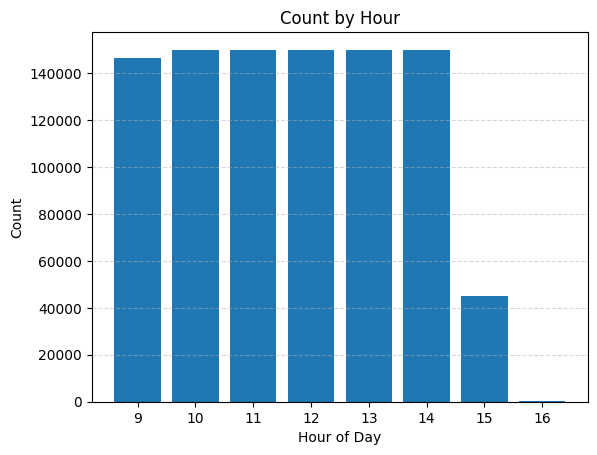

In [75]:
hourly_counts = df.groupby(df.index.hour).count().iloc[:, 0]

# 시각화
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.title('Count by Hour')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

기본적으로 장은 9-14시에 확정적으로 열려있다. 데이터 수가 적은 9시, 15시와 16시의 경우 추가 분석이 필요하다.   
1. 15시의 경우, 장이 닫히는 시간이 정시가 아니라 45분이기 때문에 상대적으로 데이터 수가 부족한 것이다. (줄기잎그래프를 통해 확인)  
2. 16시의 경우, 수능으로 인해 장의 개폐가 늦어져 발생한다. 2017년은 포항 지진으로 인해 수능이 밀렸기 때문에 2번 16시까지 장이 열렸다.  
    출처 : https://www.donga.com/news/Economy/article/all/20191114/98354291/2   
3. 2016.08.01부터 장이 30분 더 길어졌다. (15:15 -> 15:45)  
    출처 : https://blog.naver.com/dream_asset/220771772282  
4. 9시의 경우, 수능 때와 1/2 연초에 장이 늦게 열린다.  
    출처 : https://www.samsungpop.com/ux/kor/customer/notice/notice/noticeViewContent.do?MenuSeqNo=21797 

In [184]:
# 16시에 해당하는 날짜만 추출
upper_16 = df[df.index.hour == 16].index.date
unique_dates = pd.to_datetime(list(set(upper_16)))  # 중복 제거 + datetime 형식 변환

# 줄기-잎 자료구조에 날짜 정보 저장
stem_leaf = defaultdict(list)

# 날짜 관련 정보 수집
for d in unique_dates:
    d = d.date()  # datetime.date 객체로 변환
    year = d.year
    month_day = f"{d.month:02d}{d.day:02d}"  # MMDD

    # 주차(ISO week number), 요일(예: Mon)
    week = d.isocalendar()[1]
    weekday = d.strftime('%a')  # Mon, Tue, ...

    leaf = f"{month_day} (W{week}-{weekday})"
    stem_leaf[year].append(leaf)

# 정렬해서 출력
for year in sorted(stem_leaf):
    leaves = ' '.join(sorted(stem_leaf[year]))
    print(f"{year} | {leaves}")

2010 | 1118 (W46-Thu)
2011 | 1110 (W45-Thu)
2012 | 1108 (W45-Thu)
2013 | 1107 (W45-Thu)
2014 | 1113 (W46-Thu)
2015 | 1112 (W46-Thu)
2016 | 1117 (W46-Thu)
2017 | 1116 (W46-Thu) 1123 (W47-Thu)
2018 | 1115 (W46-Thu)
2019 | 1114 (W46-Thu)


In [242]:
# 1시간마다 그룹핑 → 각 시간에 몇 개의 행이 있는지 세기
under_60_data_list = []

minute_counts = df.resample('h').size()  # 1시간마다 개수 세기

# 60분 미만인 시간만 필터링
incomplete_hours = minute_counts[minute_counts < 59]

# 결과 출력
print("다 채워지지 않은 1시간 구간들:")
for ts, count in incomplete_hours.items():
    if count != 0:
        print(f"{ts} -> {count}분 있음")
        under_60_data_list.append([ts, ts.time(), count])

다 채워지지 않은 1시간 구간들:
2010-02-16 15:00:00 -> 7분 있음
2010-02-17 15:00:00 -> 7분 있음
2010-02-18 15:00:00 -> 7분 있음
2010-02-19 15:00:00 -> 7분 있음
2010-02-22 15:00:00 -> 8분 있음
2010-02-23 15:00:00 -> 7분 있음
2010-02-24 15:00:00 -> 8분 있음
2010-02-25 15:00:00 -> 7분 있음
2010-02-26 15:00:00 -> 8분 있음
2010-03-02 15:00:00 -> 7분 있음
2010-03-03 15:00:00 -> 7분 있음
2010-03-04 15:00:00 -> 7분 있음
2010-03-05 15:00:00 -> 7분 있음
2010-03-08 15:00:00 -> 7분 있음
2010-03-09 15:00:00 -> 8분 있음
2010-03-10 15:00:00 -> 7분 있음
2010-03-11 15:00:00 -> 7분 있음
2010-03-12 15:00:00 -> 7분 있음
2010-03-15 15:00:00 -> 7분 있음
2010-03-16 15:00:00 -> 7분 있음
2010-03-17 15:00:00 -> 7분 있음
2010-03-18 15:00:00 -> 7분 있음
2010-03-19 15:00:00 -> 8분 있음
2010-03-22 15:00:00 -> 7분 있음
2010-03-23 15:00:00 -> 8분 있음
2010-03-24 15:00:00 -> 7분 있음
2010-03-25 15:00:00 -> 8분 있음
2010-03-26 15:00:00 -> 7분 있음
2010-03-29 15:00:00 -> 7분 있음
2010-03-30 15:00:00 -> 7분 있음
2010-03-31 15:00:00 -> 7분 있음
2010-04-01 15:00:00 -> 7분 있음
2010-04-02 15:00:00 -> 8분 있음
2010-04-05 15:00:00 -> 7

In [243]:
under_60_data = pd.DataFrame(under_60_data_list, columns=['datetime', 'hour', 'n_data'])
under_60_data

,datetime,hour,n_data
0,2010-02-16 15:00:00,15:00:00,7
1,2010-02-17 15:00:00,15:00:00,7
2,2010-02-18 15:00:00,15:00:00,7
3,2010-02-19 15:00:00,15:00:00,7
4,2010-02-22 15:00:00,15:00:00,8
...,...,...,...
2559,2020-03-30 15:00:00,15:00:00,37
2560,2020-03-31 15:00:00,15:00:00,37
2561,2020-04-01 15:00:00,15:00:00,37
2562,2020-04-02 15:00:00,15:00:00,37


In [245]:
under_60_data['hour'].unique()

array([datetime.time(15, 0), datetime.time(16, 0), datetime.time(9, 0),
       datetime.time(12, 0), datetime.time(13, 0), datetime.time(11, 0),
       datetime.time(10, 0)], dtype=object)

/var/folders/zl/ljg24f_15m93w7f2rt14c2n80000gn/T/ipykernel_81319/2954363019.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels)


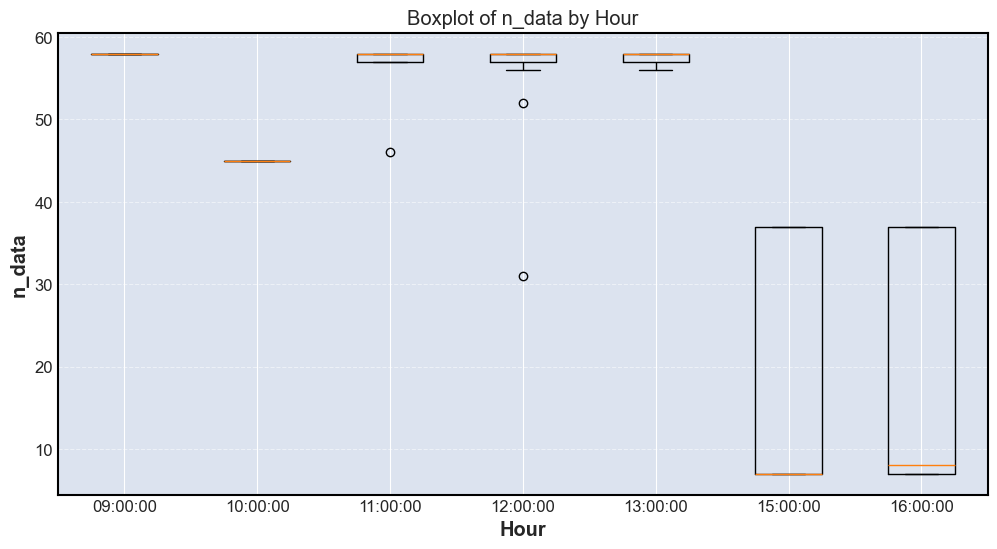

In [249]:
box_data = []
labels = []

for hour, group in under_60_data.groupby('hour'):
    box_data.append(group['n_data'].values)
    labels.append(hour)

# 박스플롯 그리기
plt.figure(figsize=(12, 6))
plt.boxplot(box_data, labels=labels)
plt.xlabel('Hour')
plt.ylabel('n_data')
plt.title('Boxplot of n_data by Hour')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

In [252]:
for hour, group in under_60_data.groupby('hour'):
    print(hour)
    print(group[['datetime','n_data']])

09:00:00
                datetime  n_data
579  2012-06-14 09:00:00      58
1290 2015-04-06 09:00:00      58
1630 2016-07-28 09:00:00      58
1930 2017-09-13 09:00:00      58
10:00:00
                datetime  n_data
2545 2020-03-13 10:00:00      45
11:00:00
                datetime  n_data
1076 2014-06-12 11:00:00      58
1567 2016-05-03 11:00:00      57
1767 2017-01-25 11:00:00      58
1918 2017-08-30 11:00:00      58
2546 2020-03-13 11:00:00      46
12:00:00
                datetime  n_data
974  2014-01-16 12:00:00      58
1062 2014-05-23 12:00:00      58
1074 2014-06-11 12:00:00      58
1089 2014-06-30 12:00:00      58
1097 2014-07-09 12:00:00      58
1188 2014-11-20 12:00:00      58
1237 2015-01-28 12:00:00      58
1248 2015-02-11 12:00:00      56
1262 2015-03-05 12:00:00      58
1288 2015-04-03 12:00:00      57
1303 2015-04-21 12:00:00      58
1366 2015-07-21 12:00:00      58
1430 2015-10-22 12:00:00      58
1536 2016-03-25 12:00:00      58
1538 2016-03-28 12:00:00      56
1560 20

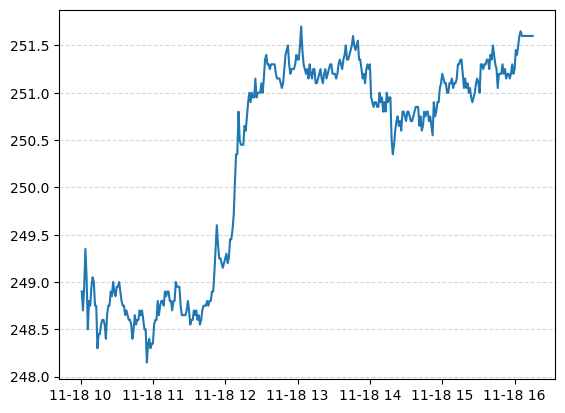

In [185]:
plt.plot(df[df.index.date == datetime.date(2010, 11, 18)]['close'])
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

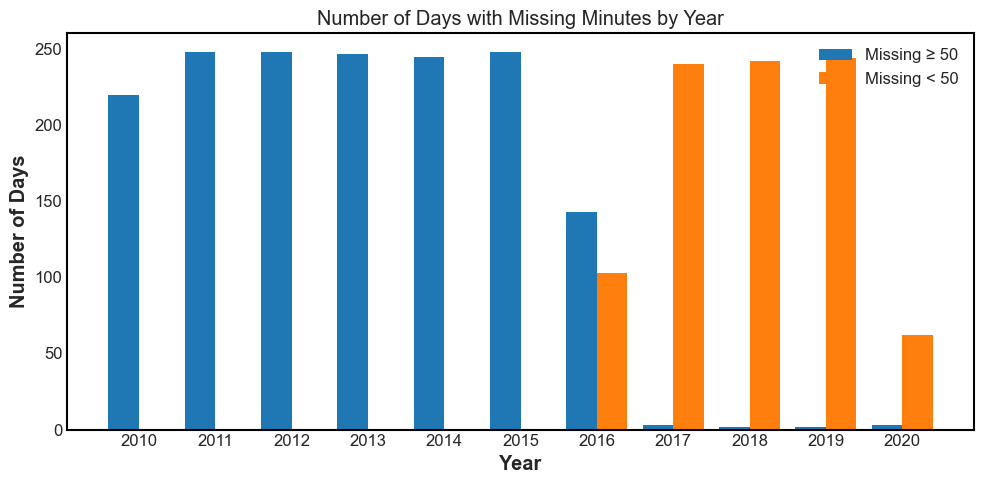

In [10]:
# ✅ 하루 중 누락된 시각 계산
missing_times_by_day = {}

for day, group in df.groupby(df.index.date):
    actual_times = group.index.time
    expected_times = [datetime.time(h, m) for h in range(9, 16) for m in range(60)]  # 09:00 ~ 15:59
    missing = [t for t in expected_times if t not in actual_times]
    if missing:
        missing_times_by_day[day] = missing

# ✅ 누락 개수 기준으로 나누기
missing_50_or_more = [day for day, times in missing_times_by_day.items() if len(times) >= 50]
missing_less_than_50 = [day for day, times in missing_times_by_day.items() if len(times) < 50]

# ✅ 연도별 누락 일수 집계 함수
def count_by_year(dates):
    years = [day.year for day in dates]
    return pd.Series(years).value_counts().sort_index()

count_50_more = count_by_year(missing_50_or_more)
count_less_50 = count_by_year(missing_less_than_50)

# ✅ 시각화
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(count_50_more.index - 0.2, count_50_more.values, width=0.4, label="Missing ≥ 50")
ax.bar(count_less_50.index + 0.2, count_less_50.values, width=0.4, label="Missing < 50")
ax.set_title("Number of Days with Missing Minutes by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Days")
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
ax.set_facecolor('white') 
fig.patch.set_facecolor('white')  # 전체 figure 배경
plt.xticks(sorted(set(count_50_more.index).union(count_less_50.index)))
plt.tight_layout()
plt.show()

2016년을 기준으로 정책이 바뀌었다.  
50이 기준인 이유 : 코드 섬세하기 짜기가 귀찮아서 8-15시까지 일괄로 봤는데, 그러다보니 장마감 시간 & 장 비공개 시간이 겹쳐서 결측치가 많다. 2016년도 8월 1일을 기준으로 장마감이 15->45분이 되었기 때문에 이후 결측치의 수가 30개 더 적다. 그럼에도 2017-부터에도 50 이상의 결측치가 나타나는 이유는 그냥,,, 순수 결측치다.  

## 연도별 추이 

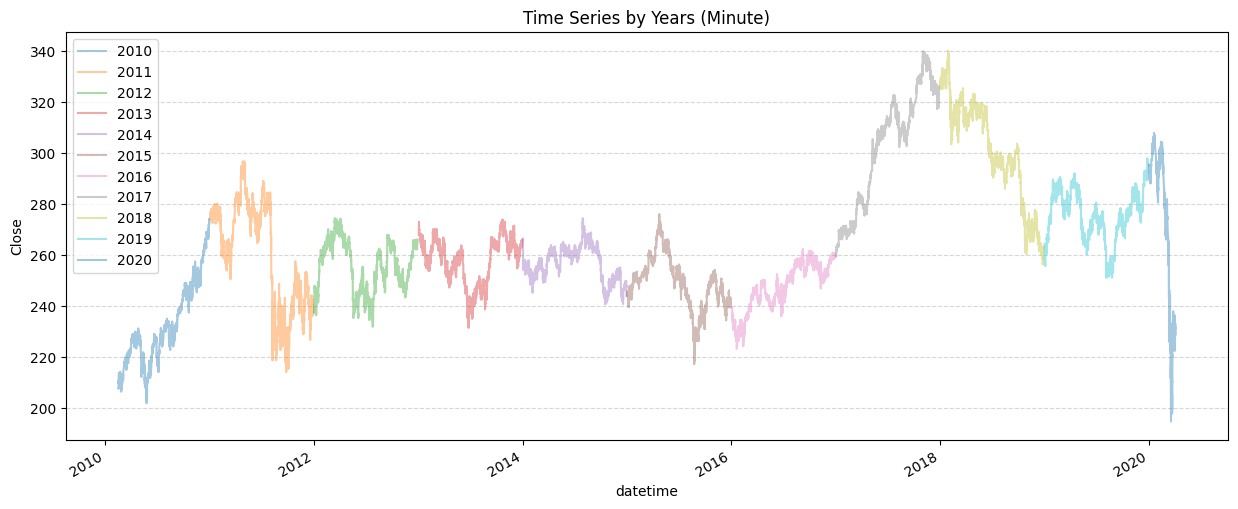

In [191]:
fig, ax = plt.subplots(figsize=(15, 6))

for key, group in df.groupby(df.index.year):
    group[['close']].plot(ax=ax, alpha=0.4)

ax.legend(list(range(2010,2021,1)))
plt.title('Time Series by Years (Minute)')
plt.ylabel('Close')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

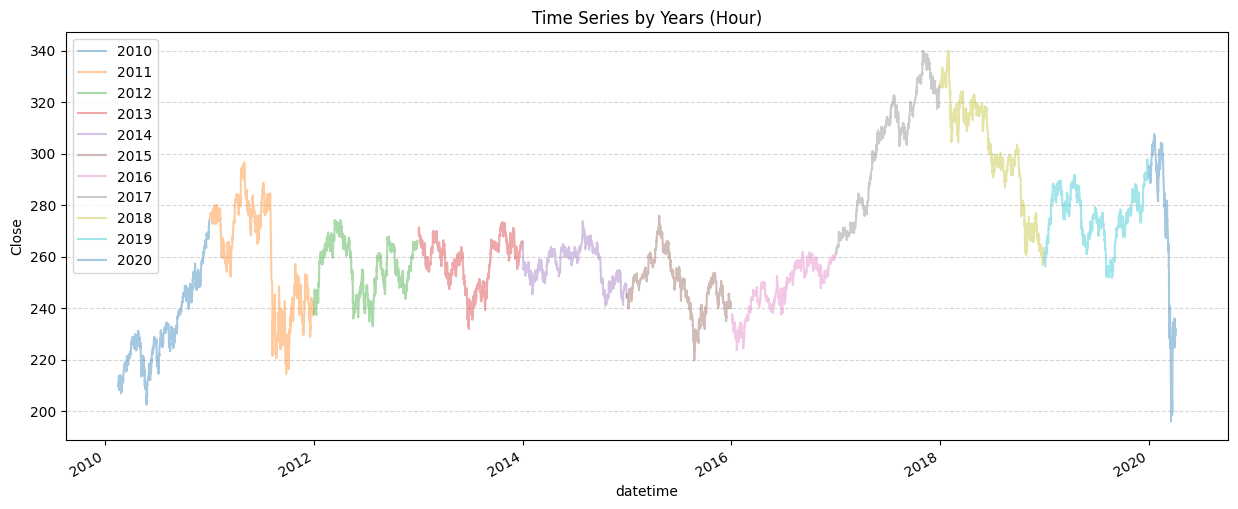

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

for key, group in h_df.groupby(h_df.index.year):
    group[['close']].plot(ax=ax, alpha=0.4)

ax.legend(list(range(2010,2021,1)))
plt.title('Time Series by Years (Hour)')
plt.ylabel('Close')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

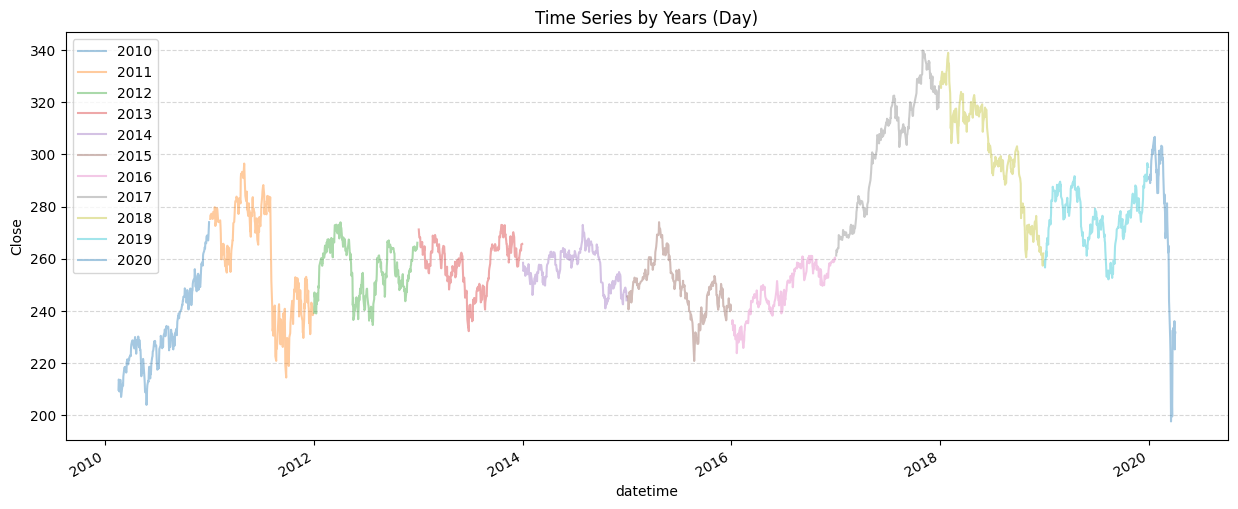

In [197]:
fig, ax = plt.subplots(figsize=(15, 6))

for key, group in d_df.groupby(d_df.index.year):
    group[['close']].plot(ax=ax, alpha=0.4)

ax.legend(list(range(2010,2021,1)))
plt.title('Time Series by Years (Day)')
plt.ylabel('Close')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

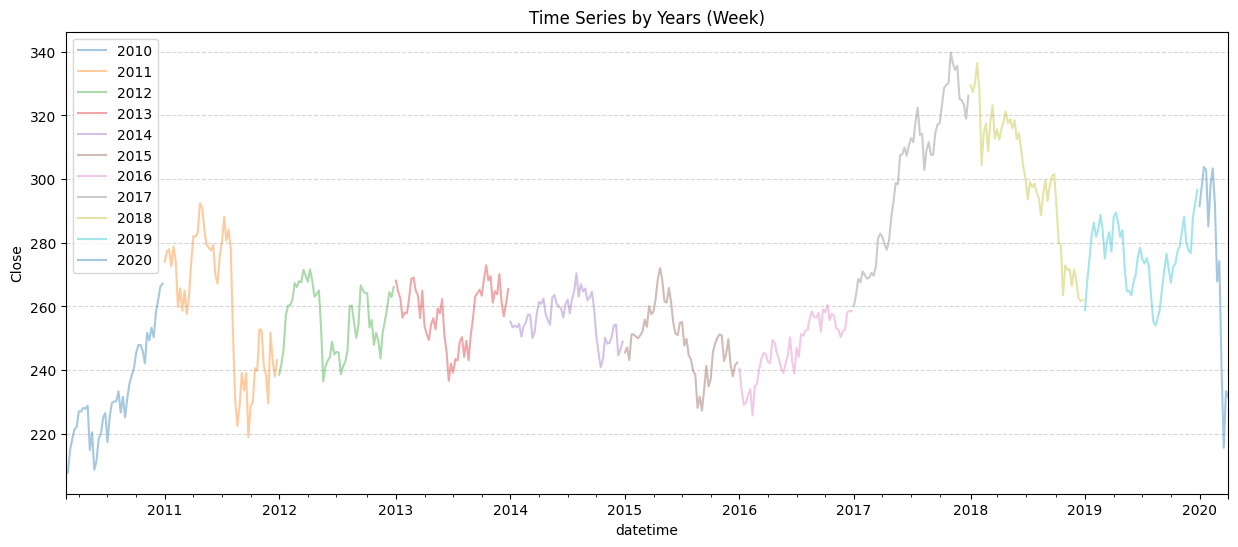

In [199]:
fig, ax = plt.subplots(figsize=(15, 6))

for key, group in w_df.groupby(w_df.index.year):
    group[['close']].plot(ax=ax, alpha=0.4)

ax.legend(list(range(2010,2021,1)))
plt.title('Time Series by Years (Week)')
plt.ylabel('Close')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

In [7]:
df['volume'] = df['vol']

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

for key, group in df.groupby(df.index.year):
    mpf.plot(group, volume=True, type='candle')

ax.legend(list(range(2010,2021,1)))
plt.title('Time Series by Years (Hour)')
plt.ylabel('Close')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

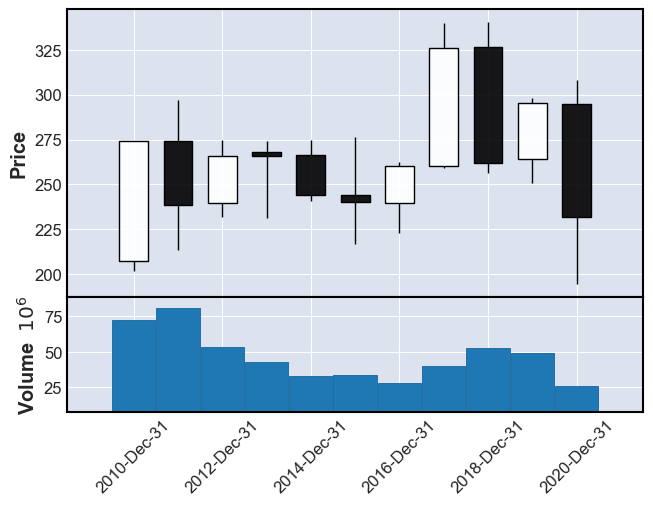

In [254]:
mpf.plot(y_df, volume=True, type='candle')

In [ ]:
mpf.plot(w_df.iloc[:100], mav=(3,6,9), volume=True, type='candle')

NameError: name 'w_df' is not defined

In [ ]:
mpf.plot(y_df, volume=True, type='candle')

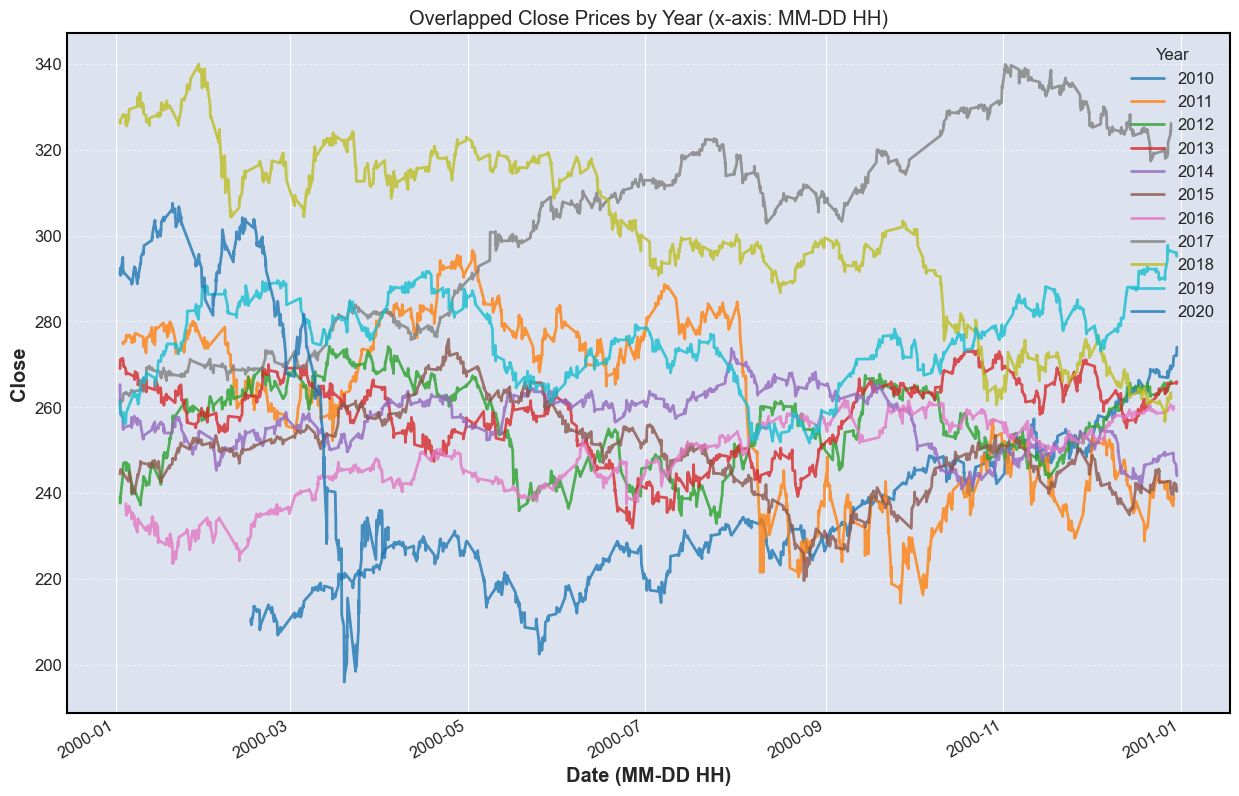

In [211]:
h_df = h_df.copy()
h_df['month_day_time'] = h_df.index.map(lambda x: pd.Timestamp(f"2000-{x.month:02d}-{x.day:02d} {x.hour:02d}:{x.minute:02d}"))

# 그래프 그리기
fig, ax = plt.subplots(figsize=(15, 10))

for year, group in h_df.groupby(h_df.index.year):
    group = group.set_index('month_day_time')
    group['close'].plot(ax=ax, alpha=0.8, label=str(year))

# 축 설정
ax.set_title('Overlapped Close Prices by Year (x-axis: MM-DD HH)')
ax.set_xlabel('Date (MM-DD HH)')
ax.set_ylabel('Close')
ax.legend(title="Year")
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

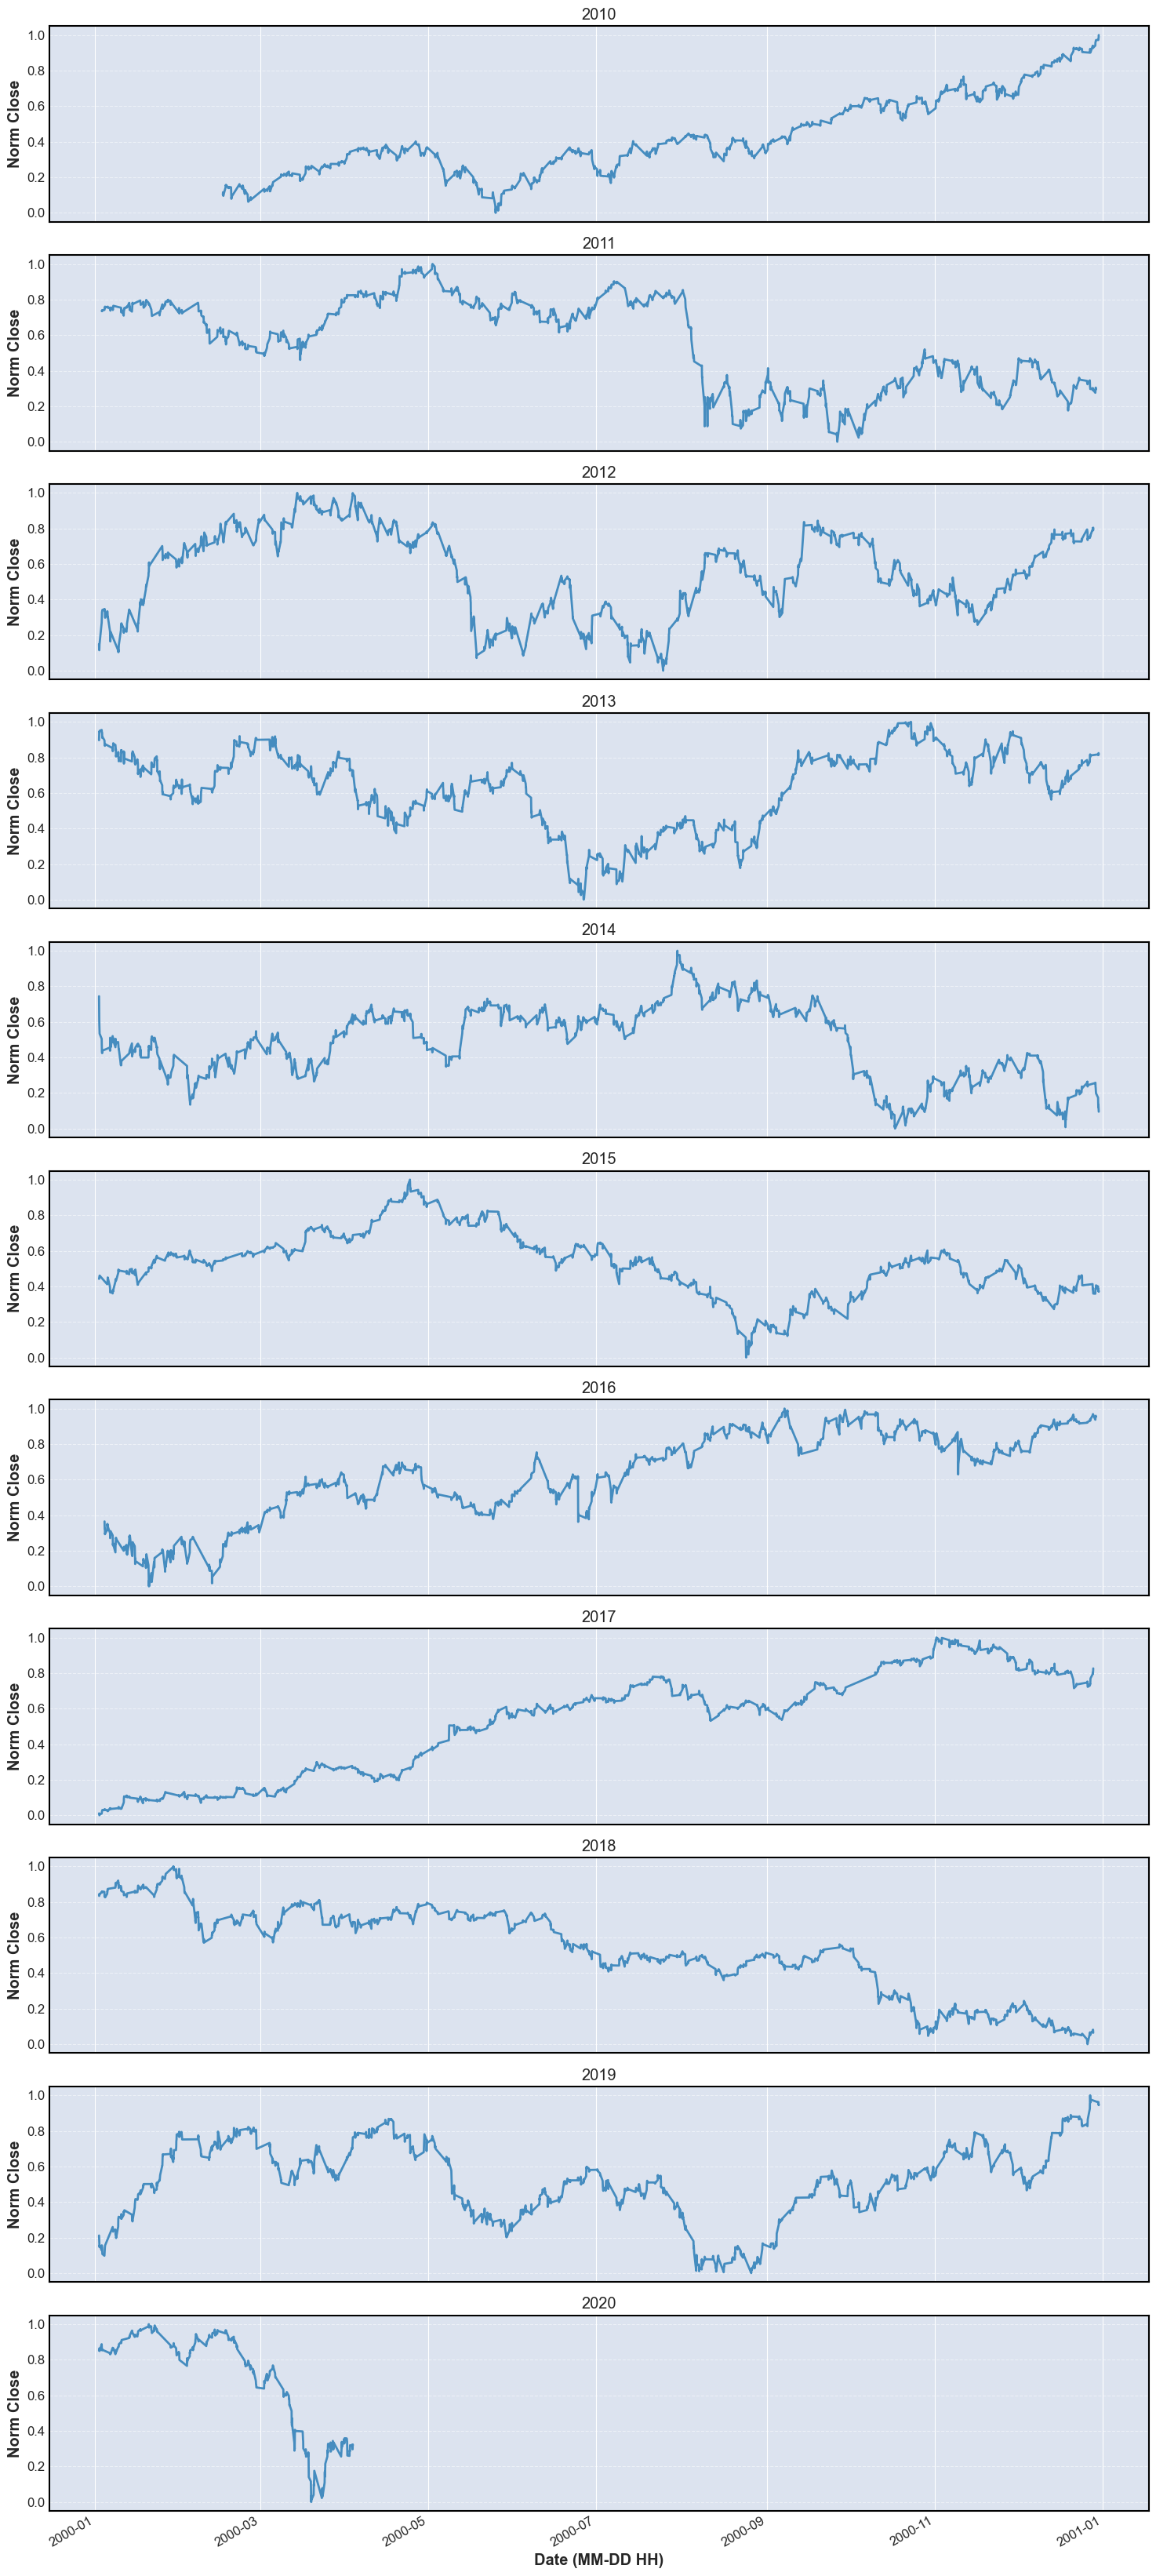

In [216]:
years = sorted(h_df.index.year.unique())

# 그래프 행 수 설정
n_years = len(years)

# 연도 무시한 x축 생성
h_df = h_df.copy()
h_df['month_day_time'] = h_df.index.map(lambda x: pd.Timestamp(f"2000-{x.month:02d}-{x.day:02d} {x.hour:02d}:{x.minute:02d}"))

# Subplots 생성 (행마다 1개, 열 1개)
fig, axes = plt.subplots(n_years, 1, figsize=(15, 3 * n_years), sharex=True)

# 각 연도별로 개별 subplot에 그리기
for ax, year in zip(axes, years):
    group = h_df[h_df.index.year == year].copy()
    
    # 정규화
    close = group['close']
    norm_close = (close - close.min()) / (close.max() - close.min())
    group['norm_close'] = norm_close
    
    # 공통 시간축으로 인덱스 설정
    group = group.set_index('month_day_time')
    
    # plot
    group['norm_close'].plot(ax=ax, label=f'{year}', alpha=0.8)
    ax.set_ylabel('Norm Close')
    ax.set_title(f'{year}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

# 공통 설정
axes[-1].set_xlabel('Date (MM-DD HH)')
plt.tight_layout()
plt.show()

In [202]:
h_df['volume'] = h_df['vol']
d_df['volume'] = d_df['vol']
w_df['volume'] = w_df['vol']
m_df['volume'] = m_df['vol']
y_df['volume'] = y_df['vol']